Codigo que resuelve el problema del obstáculo (bola) en 2d con método de Chorin, no se observan vórtices pues el método falla para densidades muy bajas.

IMPORTS E INSTALLS

In [ ]:
# instalar pyvista
!pip install pyvista

# instalar PyVirtualDisplay
!pip install PyVirtualDisplay

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.1/92.1 MB 5.8 MB/s eta 0:00:00


In [ ]:
# importar gmsh

%%capture
try:
    import gmsh
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh



In [ ]:
# importar dolfinx

%%capture
try:
    import dolfinx
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/fenicsx-install-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
    import dolfinx


In [ ]:
from dolfinx import  default_scalar_type


# importar pyvista y mas
import pyvista as pv
from pyvirtualdisplay import Display
from dolfinx.plot import vtk_mesh

display = Display(visible=0, size=(600, 400))
display.start()

pv.OFF_SCREEN=False
pv.set_jupyter_backend("static")
pv.plotting.close_all()

# gmsh
import gmsh

# ufl
import ufl

# MPI
from mpi4py import MPI

# comm
comm = MPI.COMM_WORLD

# dolfinx
import dolfinx.fem.petsc
from dolfinx.io import XDMFFile, distribute_entity_data, gmshio
from dolfinx import io, cpp, fem, mesh, plot

# PETSc
from petsc4py import PETSc
from petsc4py.PETSc import ScalarType, Mat

# SLEPc
from slepc4py import SLEPc

# numpy
import numpy as np

# pyplot
import matplotlib.pyplot as plt
from matplotlib import cm

# time
import time

# imageio
import imageio

# Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


CREACIÓN DOMINIO

In [ ]:
def create_dom2d_ball(length=3, height=1):
    gmsh.initialize()
    gmsh.model.add("rect")

    # Crear el rectángulo
    rectangle = gmsh.model.occ.addRectangle(0, 0, 0, length, height)

    # Crear el disco (círculo en 2D)
    disk = gmsh.model.occ.addDisk(length / 3, height / 2, 0, height / 6, height / 6)

    # Realizar la operación de corte
    cut = gmsh.model.occ.cut([(2, rectangle)], [(2, disk)])

    # Obtener los tags de las entidades resultantes del corte
    cut_entities = [entity[1] for entity in cut[0]]

    # Sincronizar para asegurar que las operaciones se aplican
    gmsh.model.occ.synchronize()

    tag = 1
    gdim = 2
    gmsh.model.addPhysicalGroup(dim=gdim, tags=cut_entities, tag=tag)

    # Definir un tamaño de malla más fino dentro del área rectangular
    min_size = 0.02
    max_size = 0.05

    field_tag1 = gmsh.model.mesh.field.add("Box")
    gmsh.model.mesh.field.setNumber(field_tag1, "VIn", min_size)
    gmsh.model.mesh.field.setNumber(field_tag1, "VOut", max_size)
    gmsh.model.mesh.field.setNumber(field_tag1, "XMin", length / 4)
    gmsh.model.mesh.field.setNumber(field_tag1, "XMax", length)
    gmsh.model.mesh.field.setNumber(field_tag1, "YMin", height / 4)
    gmsh.model.mesh.field.setNumber(field_tag1, "YMax", height * 3 / 4)
    gmsh.model.mesh.field.setNumber(field_tag1, "Thickness", 0.1)

    gmsh.model.mesh.field.setAsBackgroundMesh(field_tag1)

    # Generar la malla
    gmsh.model.mesh.generate(2)

    gmsh_model_rank = 0
    mesh_comm = MPI.COMM_WORLD
    domain, cell_markers, facet_markers = gmshio.model_to_mesh(model=gmsh.model, comm=mesh_comm, rank=gmsh_model_rank, gdim=gdim)

    domain.topology.create_connectivity(domain.topology.dim, 0)
    domain.topology.create_connectivity(0, domain.topology.dim)

    gmsh.finalize()

    return domain, mesh_comm

In [ ]:
rect_ball,mesh_comm = create_dom2d_ball(length=3,height =1)

with io.XDMFFile(mesh_comm,'rect_ball.xdmf','w') as xmdf:
  xmdf.write_mesh(rect_ball)


encoding=XDMFFile.Encoding.HDF5

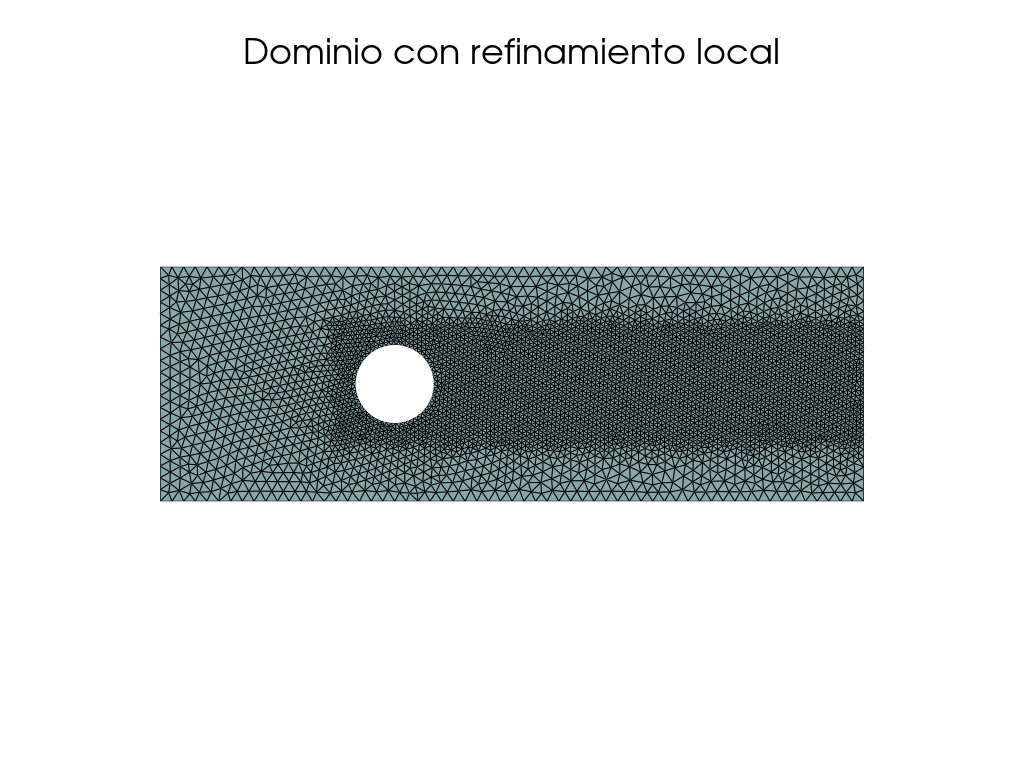

In [ ]:
# Cargar el archivo XDMF
rect_ballplot = pv.read('rect_ball.xdmf')

# Crear un plotter y visualizar la malla
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(rect_ballplot, show_edges=True)
plotter.add_title("Dominio con refinamiento local", font_size=15)
plotter.view_xy()
plotter.show()

UBICACIONES CONDICIONES DE BORDE

In [ ]:
tapa_arriba = 1
tapa_abajo = 0
tapa_izquierda = 0
tapa_derecha = 3
radio = tapa_arriba/6

def top(x , t=tapa_arriba):
  return np.isclose(x[1],t)

def but(x , t=tapa_abajo):
  return np.isclose(x[1],t)

def left(x , t=tapa_izquierda):
  return np.isclose(x[0],t)

def right(x , t=tapa_derecha):
  return np.isclose(x[0],t)

def bola(x, t =radio):
  return np.isclose((x[0]-tapa_derecha/3)**2+(x[1]-tapa_arriba/2)**2,radio**2)

SOLVER

In [ ]:
def solve(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function) -> tuple:
    # Tentative velocity step
    U = ufl.TrialFunction(Vspace)
    v = ufl.TestFunction(Vspace)

    tdim = domain.topology.dim # dimensión topológica
    fdim = tdim - 1 # reducir dimensión

    domain.topology.create_connectivity(fdim, tdim) # crear conectividad de celdas a facetas
    boundary_facets = mesh.exterior_facet_indices(domain.topology) # identificar facetas (en este caso, segmentos de línea) que corresponden a la frontera del dominio

    #vin
    bcleft_dofs = fem.locate_dofs_geometrical(Vspace, left)

    #pout
    bcright_dofs = fem.locate_dofs_geometrical(Qspace, right)

    #no slip
    bctop_dofs = fem.locate_dofs_geometrical(Vspace, top)
    bcbut_dofs = fem.locate_dofs_geometrical(Vspace, but)
    bcball_dofs = fem.locate_dofs_geometrical(Vspace, bola)

    #vin
    bcleft = fem.dirichletbc(fem.Constant(domain, ScalarType((1,0))) , bcleft_dofs, Vspace)

    #pout
    bcrightp = fem.dirichletbc(fem.Constant(domain, ScalarType((0))) , bcright_dofs, Qspace)

    #no slip
    bctop = fem.dirichletbc(ScalarType((0,0)), bctop_dofs, Vspace)
    bcbut = fem.dirichletbc(ScalarType((0,0)), bcbut_dofs, Vspace)
    bcball = fem.dirichletbc(ScalarType((0,0)), bcball_dofs, Vspace)

    # Nonlinear term
    F1 = (ufl.inner((U - uprev) / deltat, v) +
          ufl.inner(ufl.dot(ufl.grad(uprev), uprev), v) +
          nu * ufl.inner(ufl.grad(U), ufl.grad(v)) -
          ufl.inner(f, v)) * ufl.dx
    a1, L1 = ufl.lhs(F1), ufl.rhs(F1)

    # Linear problem for tentative velocity
    problem1 = fem.petsc.LinearProblem(a1, L1, bcs = [bctop , bcbut, bcball,bcleft])
    uh_star = problem1.solve()

    # Pressure correction step
    p = ufl.TrialFunction(Qspace)
    q = ufl.TestFunction(Qspace)
    a2 = ufl.inner(ufl.grad(p), ufl.grad(q)) * ufl.dx
    L2 = - (1 / deltat) * ufl.inner( ufl.div(uh_star) , q) * ufl.dx

    # Linear problem for pressure
    problem2 = fem.petsc.LinearProblem(a2, L2, bcs = [bcrightp])
    ph = problem2.solve()

    # Velocity correction step
    U_ = ufl.TrialFunction(Vspace)
    v_ = ufl.TestFunction(Vspace)

    F3 = (ufl.inner(U_, v_)  -
          ufl.inner(uh_star, v_) +
          deltat * ufl.inner(ufl.grad(ph), v_)) * ufl.dx
    a3, L3 = ufl.lhs(F3), ufl.rhs(F3)

    # Linear problem for corrected velocity
    problem3 = fem.petsc.LinearProblem(a3, L3, bcs = [bctop , bcbut, bcball,bcleft])
    uh = problem3.solve()
    return uh, ph

ITERADOR DE SOLVER

In [ ]:
def supersolve(domain: mesh.Mesh, Vspace: fem.FunctionSpace, Qspace: fem.FunctionSpace,
          uprev: fem.Function, pprev: fem.Function, deltat: float, nu: float, f:fem.Function, T:float) -> tuple:
          start_time = time.time()
          t = deltat
          upr = uprev
          ppr = pprev
          uH = []
          pH = []
          while t<T+10**(-5):
            if np.isclose(t,1.0, atol=1e-04):
              end_time = time.time()
              time_aprox = (end_time - start_time)*T
              print("Tiempo aprox: "+ str(round(time_aprox // 60)) + " minutos y " + str(round(time_aprox % 60))+ " segundos.")
            if np.isclose(t%1,0.0,atol=1e-04) or np.isclose(t%1,1,atol=1e-04):
              print("t: " + str(round(t)))
            uh, ph = solve(domain, Vspace, Qspace, upr, ppr, deltat, nu,f)
            uH.append(uh)
            pH.append(ph)
            upr = uh
            ppr = ph
            t+=deltat
          return uH,pH

CONDICIONES INICIALES, DENSIDAD, MÁS PARÁMETROS Y RESOLVER

In [ ]:
domain = rect_ball

Vspace = fem.functionspace(domain, ("Lagrange", 1, (2,)))
Qspace = fem.functionspace(domain, ("Lagrange", 1))
pprev = fem.Constant(domain, ScalarType((0)))
uprev = fem.Constant(domain, ScalarType((0,0)))


deltat = 0.025
nu = 0.05
f = fem.Constant(domain, ScalarType((0,0)))
uH, pH = supersolve(domain, Vspace, Qspace, uprev, pprev, deltat, nu,f,10)

Tiempo aprox: 2 minutos y 41 segundos.
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10


PLOTS SOLUCIÓN EN ESTADO FINAL

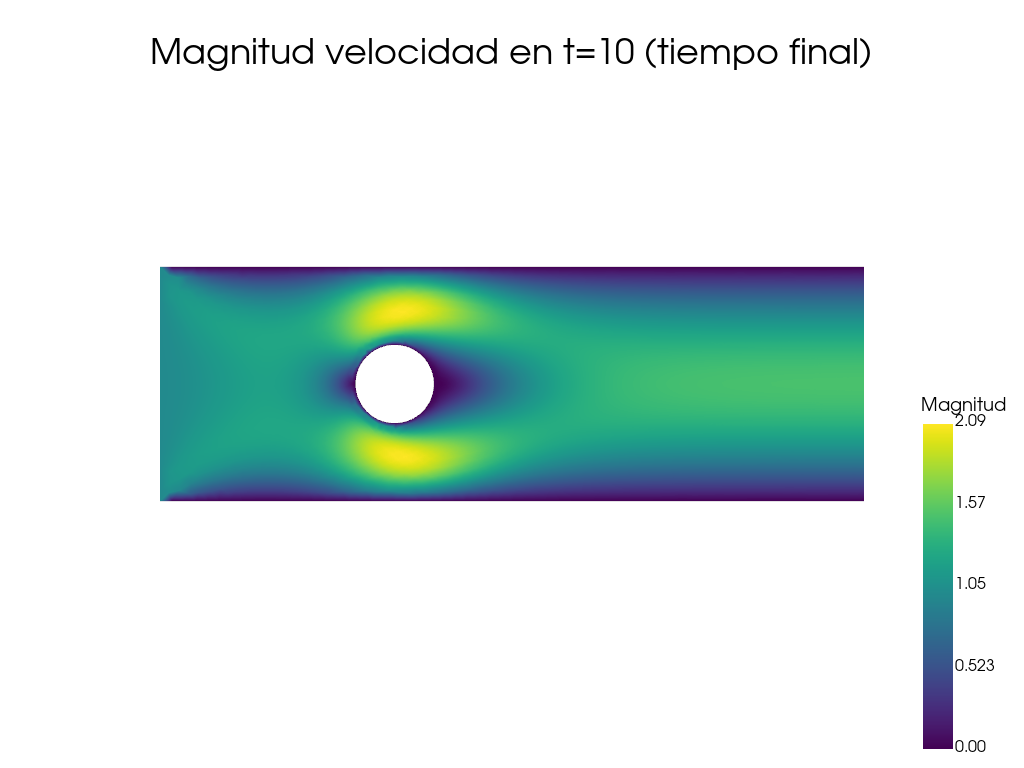

In [ ]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1)
grid.set_active_scalars("uhmag")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_title("Magnitud velocidad en t=10 (tiempo final)", font_size=15)
plotter.view_xy()

plotter.show()

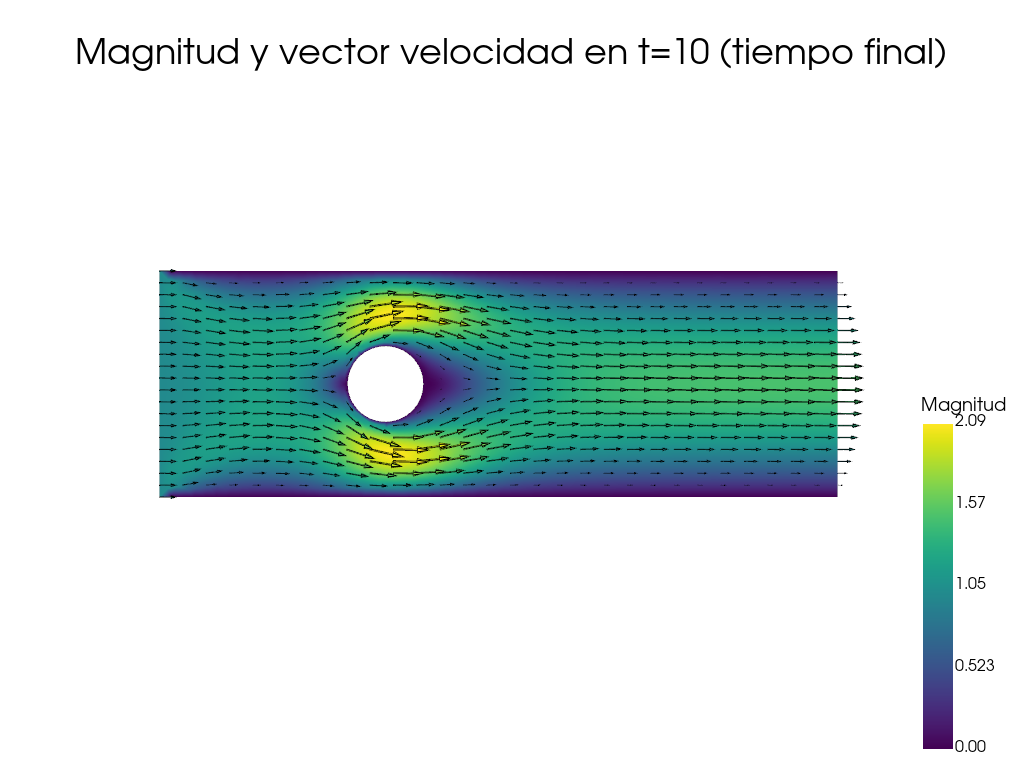

In [ ]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid.point_data["uh"] = np.vstack((uh.x.array.reshape(-1,2)[:,0],
                                   uh.x.array.reshape(-1,2)[:,1],
                                   np.zeros_like(uh.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh


grid.set_active_scalars("uhmag") # activar magnitud de uh como escalar para graficar
grid.set_active_vectors("uh") # activar uh como vectores para graficar

Lx=3
Ly=1
nx_new=30
ny_new=20
xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
resampled_grid = sample_grid.sample(pass_point_data = True, target = grid)

glyphs = resampled_grid.glyph(orient = "uh", factor = 0.08) # crear glyph (flechas en direcciones)


plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_mesh(glyphs, cmap="viridis", lighting=False, scalars="uhmag", show_edges=True, show_scalar_bar=False)
plotter.add_title("Magnitud y vector velocidad en t=10 (tiempo final)", font_size=15)
plotter.view_xy() # mismo gráfico, pero en plano xy

plotter.show()

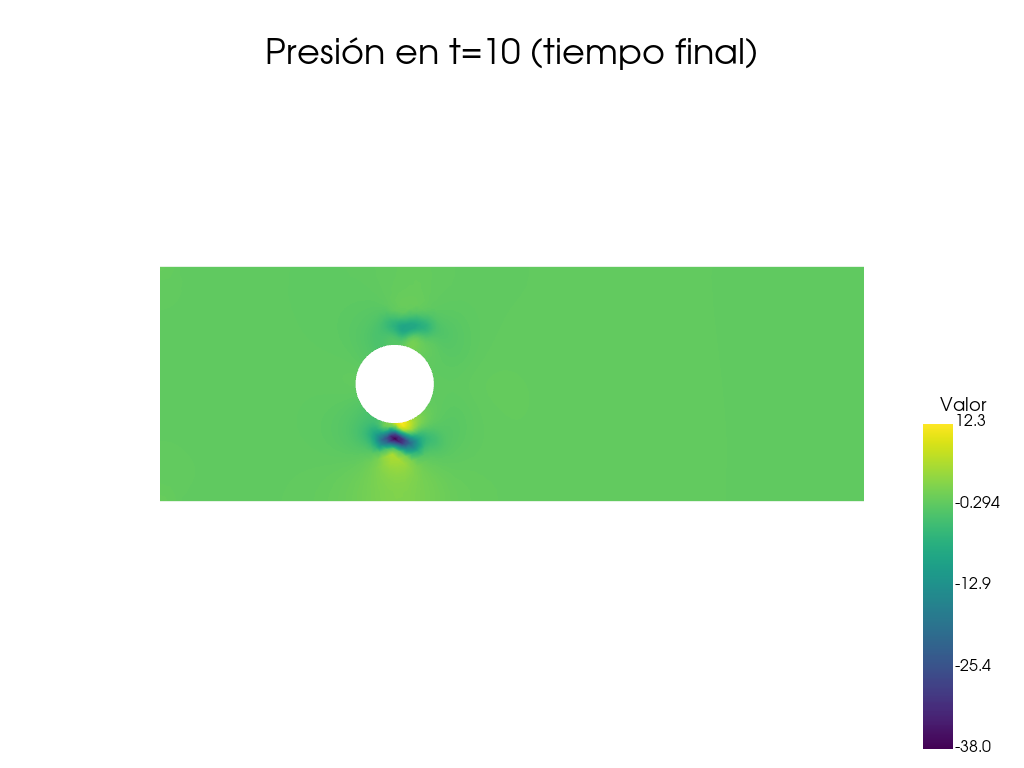

In [ ]:
ph = pH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["ph"] = ph.x.array
grid.set_active_scalars("ph")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Valor", "label_font_size": 16})
plotter.add_title("Presión en t=10 (tiempo final)", font_size=15)
plotter.view_xy()

plotter.show()

ALMACENAR FRAMES EN DRIVE DE LOS GRÁFICOS

In [ ]:
for i in range(len(uH)):
    uh = uH[i]
    connectivity = domain.topology.connectivity(domain.topology.dim, 0)
    links = connectivity.array

    cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1, 3)])
    cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype=np.uint8)
    x = domain.geometry.x

    pv.plotting.close_all()

    plotter = pv.Plotter(notebook=False, off_screen=True)  # Cambiado a False para evitar conflictos en el notebook

    grid = pv.UnstructuredGrid(cells, cell_types, x)
    grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1, 2), axis=1)
    grid.set_active_scalars("uhmag")

    plotter.add_mesh(grid, cmap="viridis", lighting=False, scalars="uhmag", show_edges=False, show_scalar_bar=True, clim=[0, 2.5],scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
    times = [round((i+1)*0.025,3) for i in range(len(uH))]
    formatted_times = [f"{num:.3f}" for num in times]
    plotter.add_title(f"Magnitud velocidad en t = "+formatted_times[i], font_size=15)
    plotter.view_xy()
    if i+1 < 10:
      plot_file_path = f'/content/drive/My Drive/PROYECTO_EDPN/magvChorin2D/plot_uH_00{i+1}.png'
    elif 10<= i+1 <100:
      plot_file_path = f'/content/drive/My Drive/PROYECTO_EDPN/magvChorin2D/plot_uH_0{i+1}.png'
    else:
      plot_file_path = f'/content/drive/My Drive/PROYECTO_EDPN/magvChorin2D/plot_uH_{i+1}.png'
    plotter.screenshot(plot_file_path)  # Guardar el plot como imagen
    plotter.close()  # Cerrar el plotter para liberar recursos

In [ ]:
for i in range(len(uH)):
    uh = uH[i]
    connectivity = domain.topology.connectivity(domain.topology.dim , 0)
    links = connectivity.array

    cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
    cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
    x = domain.geometry.x

    pv.plotting.close_all()

    plotter = pv.Plotter(notebook = True)

    grid = pv.UnstructuredGrid(cells, cell_types, x)
    grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1, 2), axis=1)
    grid.point_data["uh"] = np.vstack((uh.x.array.reshape(-1,2)[:,0],
                                      uh.x.array.reshape(-1,2)[:,1],
                                      np.zeros_like(uh.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh


    grid.set_active_scalars("uhmag") # activar magnitud de dw como escalar para graficar
    grid.set_active_vectors("uh") # activar dw como vectores para graficar

    Lx=3
    Ly=1
    nx_new=30
    ny_new=20
    xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
    points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
    sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
    resampled_grid = sample_grid.sample(pass_point_data = True, target = grid)

    glyphs = resampled_grid.glyph(orient = "uh", factor = 0.08) # crear glyph (flechas en direcciones)

    plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True, clim=[0, 2.5],scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
    plotter.add_mesh(glyphs, cmap="viridis", lighting=False, scalars="uhmag", show_edges=True, show_scalar_bar=False)
    times = [round((i+1)*0.025,3) for i in range(len(uH))]
    formatted_times = [f"{num:.3f}" for num in times]
    plotter.add_title(f"Magnitud y vector velocidad en t = "+formatted_times[i], font_size=15)
    plotter.view_xy() # mismo gráfico, pero en plano xy

    if i+1 < 10:
      plot_file_path = f'/content/drive/My Drive/PROYECTO_EDPN/vecvChorin2D/plot_uH_00{i+1}.png'
    elif 10<= i+1 <100:
      plot_file_path = f'/content/drive/My Drive/PROYECTO_EDPN/vecvChorin2D/plot_uH_0{i+1}.png'
    else:
      plot_file_path = f'/content/drive/My Drive/PROYECTO_EDPN/vecvChorin2D/plot_uH_{i+1}.png'
    plotter.screenshot(plot_file_path)  # Guardar el plot como imagen
    plotter.close()  # Cerrar el plotter para liberar recursos

In [ ]:
for i in range(len(pH)):
    ph = pH[i]
    connectivity = domain.topology.connectivity(domain.topology.dim , 0)
    links = connectivity.array

    cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
    cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
    x = domain.geometry.x

    pv.plotting.close_all()

    plotter = pv.Plotter(notebook = True)

    grid = pv.UnstructuredGrid(cells, cell_types, x)
    grid.point_data["ph"] = ph.x.array
    grid.set_active_scalars("ph")

    plotter.add_mesh(grid, cmap="viridis", lighting=False, scalars="ph", show_edges=False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Valor", "label_font_size": 16})
    times = [round((i+1)*0.025,3) for i in range(len(pH))]
    formatted_times = [f"{num:.3f}" for num in times]
    plotter.add_title(f"Presión en t = "+formatted_times[i], font_size=15)
    plotter.view_xy()

    if i+1 < 10:
      plot_file_path = f'/content/drive/My Drive/PROYECTO_EDPN/pChorin2D/plot_pH_00{i+1}.png'
    elif 10<= i+1 <100:
      plot_file_path = f'/content/drive/My Drive/PROYECTO_EDPN/pChorin2D/plot_pH_0{i+1}.png'
    else:
      plot_file_path = f'/content/drive/My Drive/PROYECTO_EDPN/pChorin2D/plot_pH_{i+1}.png'
    plotter.screenshot(plot_file_path)  # Guardar el plot como imagen
    plotter.close()  # Cerrar el plotter para liberar recursos

PROBAMOS CON MENOR DENSIDAD PERO FALLA

In [ ]:
domain = rect_ball

Vspace = fem.functionspace(domain, ("Lagrange", 1, (2,)))
Qspace = fem.functionspace(domain, ("Lagrange", 1))
pprev = fem.Constant(domain, ScalarType((0)))
uprev = fem.Constant(domain, ScalarType((0,0)))


deltat = 0.025
nu = 0.005
f = fem.Constant(domain, ScalarType((0,0)))
uH, pH = supersolve(domain, Vspace, Qspace, uprev, pprev, deltat, nu,f,10)

Tiempo aprox: 1 minutos y 34 segundos.
t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8
t: 9
t: 10


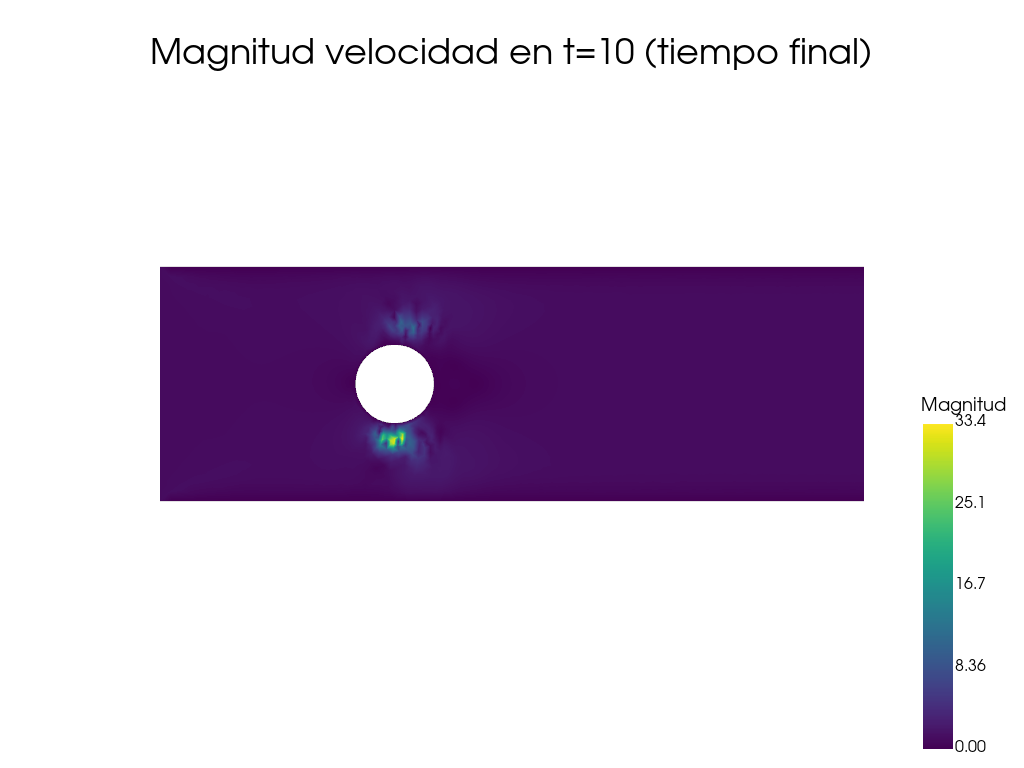

In [ ]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["uhmag"] = np.linalg.norm(uh.x.array.reshape(-1,2), axis = 1)
grid.set_active_scalars("uhmag")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_title("Magnitud velocidad en t=10 (tiempo final)", font_size=15)
plotter.view_xy()

plotter.show()

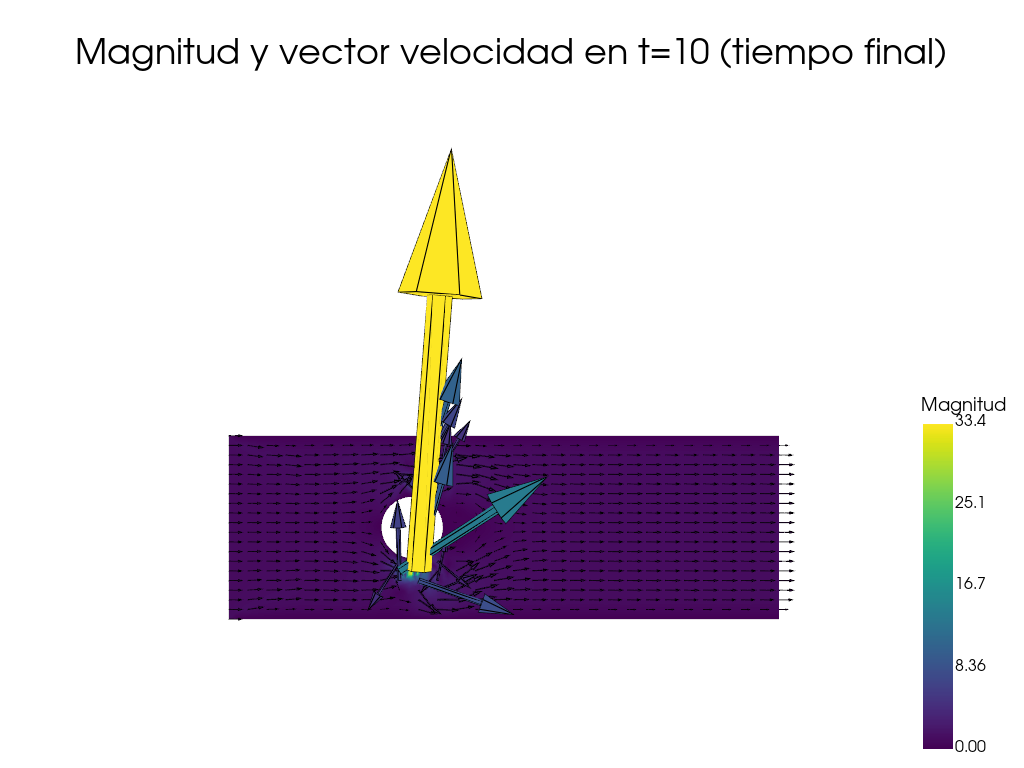

In [ ]:
uh = uH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid.point_data["uh"] = np.vstack((uh.x.array.reshape(-1,2)[:,0],
                                   uh.x.array.reshape(-1,2)[:,1],
                                   np.zeros_like(uh.x.array.reshape(-1,2)[:,0]))).T # agregar vector de uh


grid.set_active_scalars("uhmag") # activar magnitud de uh como escalar para graficar
grid.set_active_vectors("uh") # activar uh como vectores para graficar

Lx=3
Ly=1
nx_new=30
ny_new=20
xx, yy = np.meshgrid(np.linspace(0, Lx, nx_new), np.linspace(0, Ly, ny_new))
points = np.column_stack((xx.flatten(), yy.flatten(), np.zeros(nx_new*ny_new)))
sample_grid = pv.StructuredGrid(xx, yy, np.zeros_like(xx))
resampled_grid = sample_grid.sample(pass_point_data = True, target = grid)

glyphs = resampled_grid.glyph(orient = "uh", factor = 0.08) # crear glyph (flechas en direcciones)


plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Magnitud", "label_font_size": 16})
plotter.add_mesh(glyphs, cmap="viridis", lighting=False, scalars="uhmag", show_edges=True, show_scalar_bar=False)
plotter.add_title("Magnitud y vector velocidad en t=10 (tiempo final)", font_size=15)
plotter.view_xy() # mismo gráfico, pero en plano xy

plotter.show()

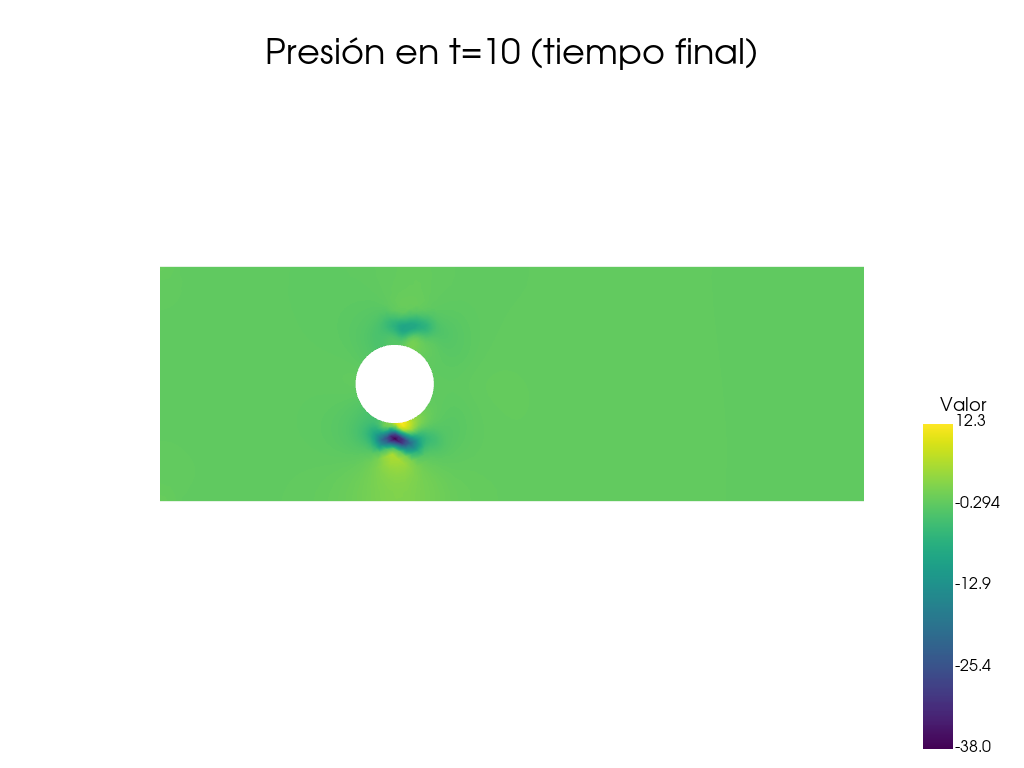

In [ ]:
ph = pH[-1]
connectivity = domain.topology.connectivity(domain.topology.dim , 0)
links = connectivity.array

cells = np.hstack([np.full(connectivity.num_nodes, 3)[..., None], links.reshape(-1,3)])
cell_types = np.full(connectivity.num_nodes, pv.CellType.TRIANGLE, dtype = np.uint8)
x = domain.geometry.x

pv.plotting.close_all()

plotter = pv.Plotter(notebook = True)

grid = pv.UnstructuredGrid(cells, cell_types, x)
grid.point_data["ph"] = ph.x.array
grid.set_active_scalars("ph")

plotter.add_mesh(grid, cmap = "viridis", lighting = False, show_scalar_bar=True,scalar_bar_args={"vertical": True, "title": "Valor", "label_font_size": 16})
plotter.add_title("Presión en t=10 (tiempo final)", font_size=15)
plotter.view_xy()

plotter.show()

Por esto probamos con un método distinto.